# Citywide Crash Predictive ML Model

We will create a Logistic Regression or Tree based model to predict the daily number of crashes at a known intersection using the following:
- weather (temp, snow, rain, precip)
- day of week (Mon, Tues...)
- intersection characteristics
    - speed limit
    - volume of traffic
    - region
    - lanes/ways/turns/split/exit etc.
- violations (may want a violations independent model)
- red light cam present

In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, r2_score
from modules.myfuncs import *
from sklearn.model_selection import GridSearchCV, cross_val_score


import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')


# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support


import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
conn = create_connection('database/rlc.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc.db



We will try to get data that is daily for all of the above info.  

In [3]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('all_hours',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('rlc_all_hours',), ('daily_covid',), ('holidays',)]
cam_locations
	camera_id
	intersection
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

cam_startend
	camera_id
	start
	end

daily_violations
	intersection
	camera_id
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

all_crashes
	crash_record_id
	rd_no
	crash_date
	posted_speed_limit
	traffic_control_device
	device_condition
	weather_condition
	lighting_condition
	first_crash_type
	trafficway_type
	alignment
	roadway_surface_cond
	road_defect
	report_type
	crash_type
	damage
	prim_contributory_cause
	sec_contributory_cause
	street_no
	street_direction
	street_name
	beat_of_occurrence
	num_units
	most_severe_injury
	in

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [4]:
# Approximately how many entries should I expect to be looking at after filtering my data
# 3 years, 4 months x 153 intersections
print((365.25*3 + 30*4) *153)


186009.75


## Query my db to get a DataFrame with crashes and intersection
We will be using the number of crashes and injuries to do some t-tests

In [5]:
# To change from citywide to signal crashes only, change cr query from all_crashes to signal_crashes (line 31)
# Query takes 5+ minutes

big_df = pd.read_sql_query('''
WITH v AS(SELECT  SUM(violations) as violations,
            year,
            month,
            day

    FROM daily_violations
    GROUP BY year, month, day
    ),

    ah AS(SELECT year,
                month,
                day,
                hour,
                datetime
            FROM all_hours
            GROUP BY year, month, day, hour
        ), 

    cr AS(SELECT strftime('%m',crash_date) AS month,
                strftime('%Y',crash_date) AS year,
                strftime('%d',crash_date) AS day,
                strftime('%H',crash_date) AS hour,
                crash_record_id,
                injuries_total,
                injuries_fatal
                
         FROM signal_crashes
        ),

    wx AS(SELECT MAX(temp) AS temp,
                (SUM(snow_1h) + SUM(rain_1h)) AS precip,
                SUM(snow_1h) AS snow_1h,
                SUM(rain_1h) AS rain_1h,
                year,
                month,
                day,
                hour,
                weather_main
        FROM hourly_weather
        GROUP BY year, month, day, hour
        ),
    
    cov AS(SELECT strftime('%m',lab_report_date) AS month,
                strftime('%Y',lab_report_date) AS year,
                strftime('%d',lab_report_date) AS day,
                lab_report_date,
                cases_total
            FROM daily_covid as dc
            GROUP BY year, month, day
            ),
            
     cg AS(SELECT 
             (100 - AVG(quantile_speed))/100 as congestion,
             year,
             month,
             day,
             hour
         FROM hourly_congestion
         GROUP BY year, month, day, hour
     )
            
    SELECT  strftime('%W',ah.datetime) AS week,
            strftime('%w',ah.datetime) AS weekday,
            ah.datetime,
            ah.year,
            ah.month,
            ah.day,
            ah.hour,

            COUNT(DISTINCT cr.crash_record_id) as n_crash,

            SUM(cr.injuries_total) AS injuries,
            SUM(cr.injuries_fatal) AS injuries_fatal,

            wx.weather_main,
            wx.temp,
            wx.precip,
            wx.snow_1h,
            wx.rain_1h,
            
            v.violations,
            
            cg.congestion,
            
            cov.cases_total
            

    FROM ah
    LEFT JOIN wx
        ON wx.year = ah.year
        AND wx.month = ah.month
        AND wx.day = ah.day  
        AND wx.hour = ah.hour
    LEFT JOIN cr
        ON cr.year = ah.year
        AND cr.month = ah.month
        AND cr.day = ah.day
        AND cr.hour = ah.hour
    LEFT JOIN cg
        ON cg.year = ah.year
        AND cg.month = ah.month
        AND cg.day = ah.day
        AND cg.hour = ah.hour
    LEFT JOIN v
        ON v.year = ah.year
        AND v.month = ah.month
        AND v.day = ah.day
    LEFT JOIN cov
        ON cov.year = ah.year
        AND cov.month = ah.month
        AND cov.day = ah.day

    WHERE ah.datetime >= \'2017-09-01\' AND ah.datetime <= \'2021-01-31\'
    GROUP BY ah.year, ah.month, ah.day, ah.hour
    ORDER BY ah.year, ah.month, ah.day, ah.hour;
                                    ''', conn)

# Change date to speed up, but put it back to sept 1, 2017 when done

## Preprocess our data

In [6]:
big_df.describe()

,year,month,day,hour,n_crash,injuries,injuries_fatal,temp,precip,snow_1h,rain_1h,violations,congestion
count,29952.000000,29952.000000,29952.000000,29952.000000,29952.000000,21477.000000,21477.000000,29952.000000,29952.000000,29952.000000,29952.000000,29952.000000,29101.000000
mean,2018.853365,6.778846,15.729167,11.500000,1.686665,0.913582,0.004610,284.960682,0.208705,0.019168,0.189537,1483.731571,0.476287
std,1.025402,3.576263,8.798660,6.922302,1.648368,1.358486,0.077366,11.227677,1.405244,0.205406,1.383383,328.382258,0.230373
min,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,245.370000,0.000000,0.000000,0.000000,546.000000,0.073339
25%,2018.000000,4.000000,8.000000,5.750000,0.000000,0.000000,0.000000,275.930000,0.000000,0.000000,0.000000,1236.750000,0.268965
50%,2019.000000,7.000000,16.000000,11.500000,1.000000,0.000000,0.000000,283.710000,0.000000,0.000000,0.000000,1455.000000,0.453991
75%,2020.000000,10.000000,23.000000,17.250000,3.000000,1.000000,0.000000,295.150000,0.000000,0.000000,0.000000,1708.750000,0.655174
max,2021.000000,12.000000,31.000000,23.000000,19.000000,21.000000,3.000000,310.370000,77.100000,16.590000,77.100000,3173.000000,0.996698


In [7]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29952 entries, 0 to 29951
Data columns (total 18 columns):
week              29952 non-null object
weekday           29952 non-null object
datetime          29952 non-null object
year              29952 non-null int64
month             29952 non-null int64
day               29952 non-null int64
hour              29952 non-null int64
n_crash           29952 non-null int64
injuries          21477 non-null float64
injuries_fatal    21477 non-null float64
weather_main      29952 non-null object
temp              29952 non-null float64
precip            29952 non-null float64
snow_1h           29952 non-null float64
rain_1h           29952 non-null float64
violations        29952 non-null int64
congestion        29101 non-null float64
cases_total       8064 non-null object
dtypes: float64(7), int64(6), object(5)
memory usage: 4.1+ MB


In [24]:
all_df = big_df.copy()
all_df['cases_total'].fillna(0, inplace=True)
all_df['cases_total'] = all_df['cases_total'].astype(int)
all_df['violations'].fillna(0, inplace=True)
all_df['congestion'].fillna(0.1, inplace=True)
all_df['datetime'] = pd.to_datetime(all_df['datetime'])

all_df['week'] = all_df['week'].astype(str)
all_df['year'] = all_df['year'].astype(str)

all_df['month'] = all_df['month'].astype(str)
all_df['weekday'] = all_df['datetime'].dt.weekday
all_df['weekday'] = all_df['weekday'].astype(str)
all_df['hour'] = all_df['hour'].astype(str)


# all_df.columns
all_df.isna().sum()

week                 0
weekday              0
datetime             0
year                 0
month                0
day                  0
hour                 0
n_crash              0
injuries          8475
injuries_fatal    8475
weather_main         0
temp                 0
precip               0
snow_1h              0
rain_1h              0
violations           0
congestion           0
cases_total          0
dtype: int64

In [25]:
all_df.weekday.unique()

array(['4', '5', '6', '0', '1', '2', '3'], dtype=object)

In [26]:
all_df.columns

Index(['week', 'weekday', 'datetime', 'year', 'month', 'day', 'hour',
       'n_crash', 'injuries', 'injuries_fatal', 'weather_main', 'temp',
       'precip', 'snow_1h', 'rain_1h', 'violations', 'congestion',
       'cases_total'],
      dtype='object')

In [27]:
# treat data as bool (did we have a wreck that day at that intersection?)
# multiple crash days will be treated as one.  Wll
y = all_df['n_crash'].fillna(0).astype(int)

drop_cols = ['day', 'injuries', 
             'injuries_fatal', 'n_crash', 'datetime']

# categoricals: week, month, weekday

X = all_df.drop(columns=drop_cols) 


In [28]:
X.columns

Index(['week', 'weekday', 'year', 'month', 'hour', 'weather_main', 'temp',
       'precip', 'snow_1h', 'rain_1h', 'violations', 'congestion',
       'cases_total'],
      dtype='object')

In [29]:
all_df['n_crash'].value_counts()
#165550 / 5245
#5245 / 137
#137/10

X_ = pd.get_dummies(X)

# drop_cols = ['snow_1h', 'hour_9', 'month_5', 'month_2', 'hour_23', 'month_8', 
#              'month_7', 'month_1', 'hour_10', 'month_6', 'hour_21', 'month_10', 
#              'hour_22', 'hour_20', 'month_4', 'hour_0']
# X_ = X_.drop(columns=drop_cols) 


X_.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29952 entries, 0 to 29951
Columns: 119 entries, temp to weather_main_Thunderstorm
dtypes: float64(5), int64(2), uint8(112)
memory usage: 4.8 MB


## Create our model

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

tree_reg = DecisionTreeRegressor() 
tree_reg.fit(X_train, y_train)
tree_reg.score(X_test, y_test)  

-0.40601977572372006

My base tree model is worse than just taking the mean

In [32]:
# SKIP THIS CELL UNLESS PERFORMING GRID Search



# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [5, 8, 10],
#     'max_features': [12, 9, 6],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [4, 8, 12],
#     'n_estimators': [200, 400, 800]
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# grid_search.fit(X_train, y_train)
# print(grid_search.best_estimator_)

In [33]:
forest = RandomForestRegressor(bootstrap=True, max_depth=30,
                      max_features=30, max_leaf_nodes=None, criterion='mse', 
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=0,
                      verbose=0, warm_start=False)

forest.fit(X_train, y_train)
print(forest.score(X_test, y_test))  # quick r2 score for tuning

0.2898727166394679


## Identify feature importance

In [34]:
def plot_feature_importances(model, X_train):
    n_features = X_train.shape[1]
    
    importance = model.feature_importances_
    features = X_train.columns.values
    df = pd.DataFrame()
    df['imp'] = importance
    df['feat'] = features
    df = df.sort_values(by=['imp'], ascending=True)

    plt.figure(figsize=(8,len(df)//2))
    plt.barh(range(len(df)), df['imp'], align='center', color='purple') 
    plt.yticks(np.arange(len(df)), df['feat'])
    plt.xticks(rotation=45)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    return list(df['feat'])

In [35]:
X_train.columns.values[:100]


array(['temp', 'precip', 'snow_1h', 'rain_1h', 'violations', 'congestion',
       'cases_total', 'week_00', 'week_01', 'week_02', 'week_03',
       'week_04', 'week_05', 'week_06', 'week_07', 'week_08', 'week_09',
       'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15',
       'week_16', 'week_17', 'week_18', 'week_19', 'week_20', 'week_21',
       'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27',
       'week_28', 'week_29', 'week_30', 'week_31', 'week_32', 'week_33',
       'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39',
       'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45',
       'week_46', 'week_47', 'week_48', 'week_49', 'week_50', 'week_51',
       'week_52', 'week_53', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'year_2017',
       'year_2018', 'year_2019', 'year_2020', 'year_2021', 'month_1',
       'month_10', 'month_11', 'month_12', 'month_2', 'month_3',


['weather_main_Smoke', 'weather_main_Haze', 'week_53', 'weather_main_Thunderstorm', 'weather_main_Fog', 'weather_main_Drizzle', 'week_19', 'week_16', 'week_33', 'week_11']


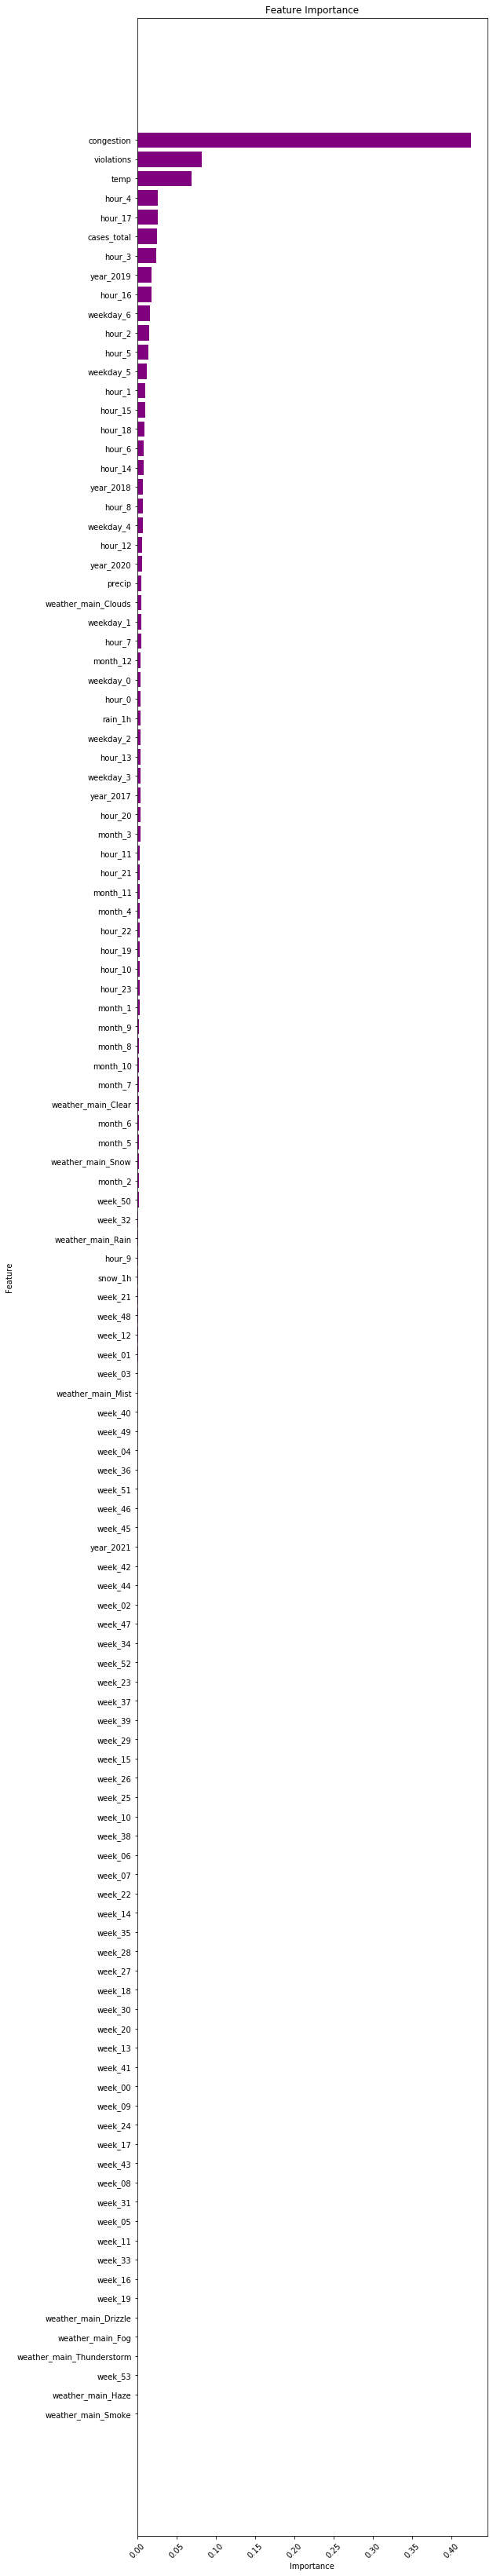

In [36]:
features = plot_feature_importances(forest, X_train)
print(features[:10])

## Plot our results and prediction

In [37]:
# create an hourly plot of actual and predicted values.
import plotly.graph_objects as go


days = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
pred = forest.predict(X_)

plotme = all_df.copy()[['datetime', 'n_crash', 'weekday', 'precip', 'congestion', 'cases_total', 'violations', 'injuries', 'temp']]

plotme['pred'] = pred
plotme['MA'] = plotme.n_crash.rolling(5, min_periods=1, center=True, win_type='triang').mean()
plotme['error'] = abs(pred - plotme.n_crash)/plotme.n_crash

plotme.temp = plotme.temp.apply(lambda x: (x-273.15)*9/5+32) # K to F conversion temp
plotme.weekday = plotme.weekday.apply(lambda x: days[int(x)])



plt.figure(figsize=[30, 5])

plotme_range = plotme[plotme['datetime'] > datetime(2017, 9, 1)]


hover_list = ['Pred crash: %{customdata[8]:.2f}',
              'Actual crash: %{customdata[10]}',
              'Error: %{customdata[9]:.1%}',
                    'Date: %{customdata[0]}',
                    "Weekday: %{customdata[1]}",
                    "Injuries: %{customdata[2]}",
                    "Precip (mm): %{customdata[3]:.1f}",
                    "Temp (F): %{customdata[4]:.1f}",
                    "Congestion: %{customdata[5]:.2f}",
                    "Daily violations: %{customdata[6]}",
                    "Covid cases: %{customdata[7]}",   
             ]



fig = px.bar(plotme_range, 
             x='datetime', 
             y='n_crash', 
             title='Chicago Hourly Crash Model',
             
             
             )
  

fig.add_scatter(x=plotme_range['datetime'],
                y=plotme_range['MA'],
                mode='lines',
                hoverinfo='skip',
                name='5hr moving avg.',
                line=dict(
                            color='rgba(220, 0, 0, 0.5)',
                            width=2
                        ),
                
    )



# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(step="all")
            ])
        ),
        type="date"
    )
)


               
    
fig.add_scatter(x=plotme_range['datetime'], 
                y=plotme_range['pred'],
                mode='markers',
                name='model prediction',
                #marker_color='black',

                marker=dict(
                            color='rgb(0,255,0)',
                            #size=5,
                            line=dict(width=1,
                                    color='DarkSlateGray'),
                            ),
                
                customdata=plotme_range[['datetime', 'weekday', 'injuries', 'precip', 'temp', 'congestion', 'violations', 'cases_total', 'pred', 'error', 'n_crash']],
                hovertemplate="<br>".join(hover_list),  # break between all items  

               )






fig.update_yaxes(range=[0, plotme_range['n_crash'].max()])
fig.update_layout(width=1200, height=500, legend=dict(x=0, y=1), hovermode='closest')






#fig.show()


# MAKE SURE YOU SELECT THE CORRECT PLOT TO OVERWRITE
fig.write_html('citywide_signalcrash_model.html')
#fig.write_html('citywide_allcrash_model.html')

<Figure size 2160x360 with 0 Axes>

### Scoring metrics for the model

In [38]:
print(y.describe())
print()
print('Cross validation score: {:.2f}'.format(cross_val_score(forest, X_, y, cv=5).mean())) # 2min
print('MAE: {:.2f}'.format(mean_absolute_error(forest.predict(X_test), y_test)))
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(forest.predict(X_test), y_test))))
print('R2 (test set): {:.2f}'.format(r2_score(y_test, forest.predict(X_test))))
print('R2 (all data): {:.2f}'.format(r2_score(y, forest.predict(X_))))

count    29952.000000
mean         1.686665
std          1.648368
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         19.000000
Name: n_crash, dtype: float64

Cross validation score: 0.24
MAE: 1.05
RMSE: 1.37
R2 (test set): 0.29
R2 (all data): 0.40


# Results
With Random Forest Regression, we were able to create a predictive model.

**All crashes (450k):**
- cv score: 0.62
- r2: 0.71
- MAE: 3.28 (mean=12.7)
- RMSE: 4.56

**Signal crashes (60k):**
- cv score: 0.24
- r2: 0.29
- MAE: 1.05  (mean=1.7)
- RMSE: 1.37

The most important variables in our model 
- congestion 
- violations
- temp
- hour
- covid_cases
- year

Note: congestion is overwhelmingly the most important feature.  Without it, both models perform poorly.

The model initially performed poorly during COVID-19 pandemic.  After introducing case numbers, it improved dramatically during that period, although the overall score did not improve significantly (+0.01).

To change the model from all crashes to signal only crashes, just alter the sql query at start of code.


## Create plot for chart studio

In [39]:
# create an hourly plot of actual and predicted values.
# Two year plot


import plotly.graph_objects as go


days = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
pred = forest.predict(X_)

plotme = all_df.copy()[['datetime', 'n_crash', 'weekday', 'precip', 'congestion', 'cases_total', 'violations', 'injuries', 'temp']]

plotme['pred'] = pred
plotme['MA'] = plotme.n_crash.rolling(5, min_periods=1, center=True, win_type='triang').mean()
plotme['error'] = abs(pred - plotme.n_crash)/plotme.n_crash

plotme.temp = plotme.temp.apply(lambda x: (x-273.15)*9/5+32) # K to F conversion temp
plotme.weekday = plotme.weekday.apply(lambda x: days[int(x)])



plt.figure(figsize=[30, 5])

plotme_range = plotme[plotme['datetime'] >= datetime(2020, 12, 1)]


hover_list = ['Pred crash: %{customdata[8]:.2f}',
              'Actual crash: %{customdata[10]}',
              'Error: %{customdata[9]:.1%}',
                    'Date: %{customdata[0]}',
                    "Weekday: %{customdata[1]}",
                    "Injuries: %{customdata[2]}",
                    "Precip (mm): %{customdata[3]:.1f}",
                    "Temp (F): %{customdata[4]:.1f}",
                    "Congestion: %{customdata[5]:.2f}",
                    "Daily violations: %{customdata[6]}",
                    "Covid cases: %{customdata[7]}",   
             ]

fig = go.Figure(
    layout=go.Layout(
        title=go.layout.Title(text="Chicago Hourly Crash Model")
    )
)


trace1 = go.Bar(
            x=plotme_range['datetime'], 
             y=plotme_range['n_crash'],    
            name='n Crashes'
             )
  

trace2 = go.Scatter(x=plotme_range['datetime'],
                y=plotme_range['MA'],
                mode='lines',
                hoverinfo='skip',
                name='5hr moving avg.',
                line=dict(
                            color='rgba(220, 0, 0, 0.5)',
                            width=2
                        ),
                
    )



# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(step="all")
            ])
        ),
        type="date"
    )
)


               
    
trace3 = go.Scatter(x=plotme_range['datetime'], 
                y=plotme_range['pred'],
                mode='markers',
                name='model prediction',
                #marker_color='black',

                marker=dict(
                            color='rgb(0,255,0)',
                            #size=5,
                            line=dict(width=1,
                                    color='DarkSlateGray'),
                            ),
                
                customdata=plotme_range[['datetime', 'weekday', 'injuries', 'precip', 'temp', 'congestion', 'violations', 'cases_total', 'pred', 'error', 'n_crash']],
                hovertemplate="<br>".join(hover_list),  # break between all items  

               )


<Figure size 2160x360 with 0 Axes>

## Load to chart studio

In [40]:
from chartstudio_api import *

In [41]:
api_key
print("Do not leave public")

Do not leave public


In [ ]:
import chart_studio

chart_studio.tools.set_credentials_file(username=api_key['username'], api_key=api_key['key'])

In [42]:
import chart_studio.plotly as py

data = [trace1, trace2, trace3]
py.plot(data, filename='allcity_crash_model', auto_open=True)


'https://plotly.com/~sciencelee/1/'

#### Partial plot of model available here:
https://chart-studio.plotly.com/~sciencelee/1.embed